In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q "git+https://github.com/facebookresearch/sam2.git"
!pip install -q "transformers>=4.41,<5" timm
#
!pip install -q opencv-python matplotlib seaborn pandas 


In [ ]:
!pip install ultralytics

In [58]:
import torch, transformers, cv2, pandas as pd, matplotlib
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Transformers:", transformers.__version__)
print("OpenCV:", cv2.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
import sam2
from pathlib import Path
from PIL import Image
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import logging, os
import time 
from ultralytics import YOLO
import numpy as np


PyTorch: 2.6.0+cu124 | CUDA available: True
Transformers: 4.52.4
OpenCV: 4.11.0
pandas: 2.2.3
matplotlib: 3.7.2


In [59]:

def create_logger(log_dir: str, name: str = "segmentation", level: str = "INFO") -> logging.Logger:
    Path(log_dir).mkdir(parents=True, exist_ok=True)
    logger = logging.getLogger(name)
    logger.setLevel(getattr(logging, level.upper(), logging.INFO))
    logger.propagate = False  # avoid duplicate logs

    # Clear old handlers if cell re-run
    if logger.handlers:
        for h in list(logger.handlers):
            logger.removeHandler(h)

    # Console handler
    ch = logging.StreamHandler()
    ch.setLevel(logger.level)

    # Simple file handler (overwrite each run)
    fh = logging.FileHandler(os.path.join(log_dir, f"{name}.log"), mode="w")
    fh.setLevel(logger.level)

    fmt = logging.Formatter(
        fmt="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    ch.setFormatter(fmt)
    fh.setFormatter(fmt)

    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger


device = 'cuda' if torch.cuda.is_available() else 'cpu'

LOG_DIR = "/kaggle/working/a3_sam2_camvid/logs"
logger = create_logger(LOG_DIR, name="segmentation", level="INFO")
logger.info("Logger initialized.")
logger.info(f"PyTorch: {torch.__version__}, CUDA available: {torch.cuda.is_available()}")
logger.info(f"Device in use: {device}")


2025-09-11 16:16:48 | INFO | segmentation | Logger initialized.
2025-09-11 16:16:48 | INFO | segmentation | PyTorch: 2.6.0+cu124, CUDA available: True
2025-09-11 16:16:48 | INFO | segmentation | Device in use: cuda


In [60]:
DATA_ROOT = Path("/kaggle/input/camvid/CamVid")
print("Files under CamVid:", list(DATA_ROOT.iterdir())[:10])

Files under CamVid: [PosixPath('/kaggle/input/camvid/CamVid/class_dict.csv'), PosixPath('/kaggle/input/camvid/CamVid/val_labels'), PosixPath('/kaggle/input/camvid/CamVid/test_labels'), PosixPath('/kaggle/input/camvid/CamVid/val'), PosixPath('/kaggle/input/camvid/CamVid/train_labels'), PosixPath('/kaggle/input/camvid/CamVid/test'), PosixPath('/kaggle/input/camvid/CamVid/train')]


In [61]:
# THIS IS TO LOAD THE DATA
DATA_ROOT = Path("/kaggle/input/camvid/CamVid")  
VAL_IMG_DIR = (DATA_ROOT/"val") if (DATA_ROOT/"val").exists() else (DATA_ROOT/"images/val")
VAL_LBL_DIR = (DATA_ROOT/"val_labels") if (DATA_ROOT/"val_labels").exists() else (DATA_ROOT/"labels/val")
CLASS_CSV   = DATA_ROOT/"class_dict.csv"

assert VAL_IMG_DIR.exists(), f"Missing val images at {VAL_IMG_DIR}"
assert VAL_LBL_DIR.exists(), f"Missing val labels at {VAL_LBL_DIR}"
assert CLASS_CSV.exists(),   f"Missing class_dict.csv at {CLASS_CSV}"

len(list(VAL_IMG_DIR.glob("*"))), len(list(VAL_LBL_DIR.glob("*"))), CLASS_CSV
logger.info(f"VAL_IMG_DIR: {VAL_IMG_DIR}")
logger.info(f"VAL_LBL_DIR: {VAL_LBL_DIR}")
logger.info(f"CLASS_CSV: {CLASS_CSV}")


2025-09-11 16:17:08 | INFO | segmentation | VAL_IMG_DIR: /kaggle/input/camvid/CamVid/val
2025-09-11 16:17:08 | INFO | segmentation | VAL_LBL_DIR: /kaggle/input/camvid/CamVid/val_labels
2025-09-11 16:17:08 | INFO | segmentation | CLASS_CSV: /kaggle/input/camvid/CamVid/class_dict.csv


In [62]:

def match_label_path(img_path: Path) -> Path:
    name = img_path.stem
    p1 = VAL_LBL_DIR / img_path.name
    if p1.exists(): return p1
    p2 = VAL_LBL_DIR / f"{name}_L.png"
    if p2.exists(): return p2
    # last resort: same stem, any ext
    cands = list(VAL_LBL_DIR.glob(name + "*"))
    if cands: return cands[0]
    raise FileNotFoundError(f"No label for {img_path.name}")

sample_img = sorted([p for p in VAL_IMG_DIR.iterdir() if p.suffix.lower() in {".png",".jpg",".jpeg"}])[0]
sample_lbl = match_label_path(sample_img)
sample_img, sample_lbl


(PosixPath('/kaggle/input/camvid/CamVid/val/0001TP_009030.png'),
 PosixPath('/kaggle/input/camvid/CamVid/val_labels/0001TP_009030_L.png'))

In [63]:
name_to_rgb = {}
with CLASS_CSV.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        cname = row.get('name') or row.get('class') or row.get('Class') or row.get('ClassName')
        r = int(row.get('r') or row.get('R') or row.get('red') or 0)
        g = int(row.get('g') or row.get('G') or row.get('green') or 0)
        b = int(row.get('b') or row.get('B') or row.get('blue') or 0)
        if cname: name_to_rgb[cname.strip()] = (r,g,b)

def _find_key(keys):
    for k in keys:
        if k in name_to_rgb: return k
    return None

CAR_KEY = _find_key(["Car","car"])
PED_KEY = _find_key(["Pedestrian","person","Pedestrians"])
BIC_KEY = _find_key(["Bicyclist","Cyclist","Bike"])

RGB_PED = name_to_rgb.get(PED_KEY, (64,0,128))
RGB_BIC = name_to_rgb.get(BIC_KEY, (0,128,192))
RGB_CAR = name_to_rgb.get(CAR_KEY, (64,64,128))

def label_to_binary_masks(label_img):
    arr = np.array(label_img.convert("RGB"))
    people = ((arr==RGB_PED).all(-1)) | ((arr==RGB_BIC).all(-1))  # This is for pedestrian + bicyclist
    vehicles = ((arr==RGB_CAR).all(-1))                           # this is for car group to find out
    return people.astype(np.uint8), vehicles.astype(np.uint8)

# testing check on the samples count 
gt_people, gt_vehicle = label_to_binary_masks(Image.open(sample_lbl))
gt_people.sum(), gt_vehicle.sum()
logger.info(f"Using RGB for Pedestrian={RGB_PED}, Bicyclist={RGB_BIC}, Car={RGB_CAR}")


2025-09-11 16:17:19 | INFO | segmentation | Using RGB for Pedestrian=(64, 64, 0), Bicyclist=(0, 128, 192), Car=(64, 0, 128)


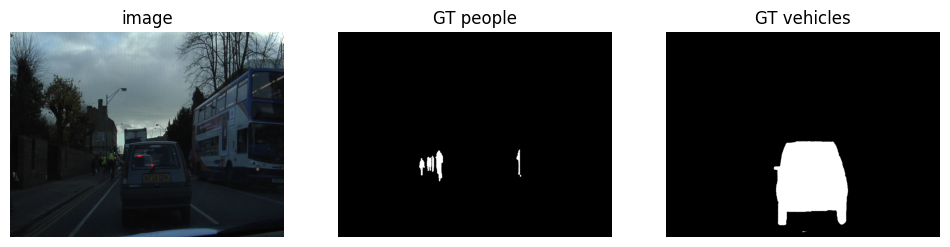

In [64]:
# cgecking whether the saple to see from the image
img = np.array(Image.open(sample_img).convert("RGB"))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gt_people, cmap="gray"); plt.title("GT people"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gt_vehicle, cmap="gray"); plt.title("GT vehicles"); plt.axis("off")
plt.show()


In [65]:
# check the dicescore of it
def dice_score(y_true, y_pred, eps=1e-6):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    inter = np.logical_and(y_true, y_pred).sum()
    return (2*inter + eps) / (y_true.sum() + y_pred.sum() + eps)

# verify the dice score
dice_score(gt_people, gt_people), dice_score(gt_vehicle, gt_vehicle)


(1.0, 1.0)

In [66]:
# loading OWLv2 zero-shot detector whichis for(text → boxes, AND WITHOUT manual clicks)
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from torchvision.ops import nms


OWL_MODEL = "google/owlv2-base-patch16"
owl_processor = AutoProcessor.from_pretrained(OWL_MODEL)
owl_model = AutoModelForZeroShotObjectDetection.from_pretrained(OWL_MODEL).to(device).eval()
logger.info(f"Loaded OWLv2 model: {OWL_MODEL}")

@torch.inference_mode()
def detect_text_boxes(img_rgb, prompts, score_thr=0.25):
    H, W = img_rgb.shape[:2]
    inputs = owl_processor(images=img_rgb, text=prompts, return_tensors="pt").to(device)
    outputs = owl_model(**inputs)
    try:
        processed = owl_processor.post_process_grounded_object_detection(
            outputs=outputs, target_sizes=[(H, W)], threshold=score_thr
        )[0]
    except Exception:
        processed = owl_processor.post_process_object_detection(outputs=outputs, target_sizes=[(H, W)])[0]
        keep = processed["scores"] >= score_thr
        for k in ("boxes","scores","labels"):
            processed[k] = processed[k][keep]

    boxes, scores = processed["boxes"], processed["scores"]  # xyxy on torch
    if boxes.numel() > 0:
        keep = nms(boxes, scores, 0.7)
        boxes, scores = boxes[keep], scores[keep]
    logger.debug(f"Prompts={prompts}, thr={score_thr}, detected {len(boxes)} boxes")
    return boxes.cpu().numpy(), scores.cpu().numpy()


2025-09-11 16:19:31 | INFO | segmentation | Loaded OWLv2 model: google/owlv2-base-patch16


In [67]:
# OWL_MODEL PROMPTING FOR THE PEOPLE AND VEHICLE
PEOPLE_PROMPTS_BASE = ["pedestrian","person","people","cyclist","bicyclist","rider"]
VEH_PROMPTS_BASE = ["car","bus","motorcycle","motorbike"]

img_rgb = np.array(Image.open(sample_img).convert("RGB"))
b_people, s_people = detect_text_boxes(img_rgb, PEOPLE_PROMPTS_BASE)
b_veh,    s_veh    = detect_text_boxes(img_rgb, VEH_PROMPTS_BASE)

b_people.shape, b_veh.shape


((6, 4), (3, 4))

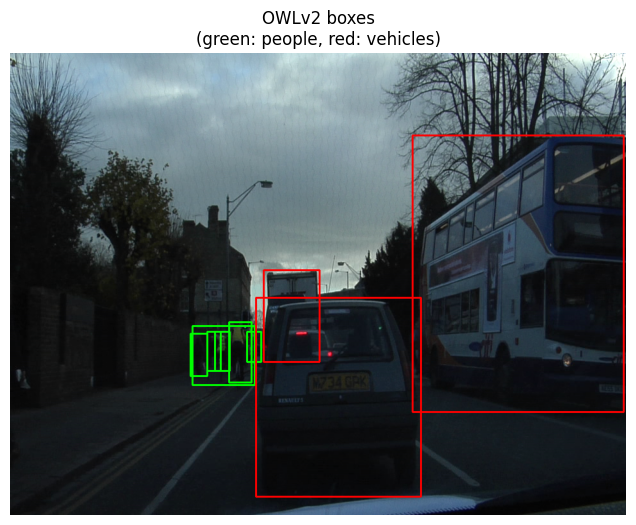

In [68]:
# VISUALIZZE THE boxes TO see what OWLv2 found

def draw_boxes(im, boxes, color=(0,255,0)):
    im = im.copy()
    for (x1,y1,x2,y2) in boxes.astype(int):
        cv2.rectangle(im, (x1,y1), (x2,y2), color, 2)
    return im

vis = draw_boxes(img_rgb, b_people, (0,255,0))
vis = draw_boxes(vis, b_veh, (255,0,0))
plt.figure(figsize=(8,6)); plt.imshow(vis); plt.title("OWLv2 boxes\n(green: people, red: vehicles)"); plt.axis("off")
plt.show()


In [69]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

SAM2_CKPT = "facebook/sam2-hiera-small"
predictor = SAM2ImagePredictor.from_pretrained(SAM2_CKPT)
logger.info(f"Loaded SAM2 checkpoint: {SAM2_CKPT}")

def _clip_boxes_to_image(boxes, H, W):
    b = boxes.copy().astype(np.float32)
    b[:, [0,2]] = np.clip(b[:, [0,2]], 0, W-1)
    b[:, [1,3]] = np.clip(b[:, [1,3]], 0, H-1)
    return b

@torch.inference_mode()
def sam2_union_mask(img_rgb, boxes_xyxy, add_center_points=False):
    """
    If add_center_points=True: run SAM2 per-box with its own center point.
    If False: batch all boxes in one call.
    Returns union mask over all prompts.
    """
    H, W = img_rgb.shape[:2]
    if boxes_xyxy.size == 0:
        return np.zeros((H, W), dtype=bool)

    predictor.set_image(img_rgb)

    if not add_center_points:
        # Fast path: batch all boxes at once
        masks, _, _ = predictor.predict(
            box=boxes_xyxy.astype(np.float32),
            multimask_output=False
        )
        if masks.ndim == 4:  # (N,1,H,W)
            masks = masks[:, 0]
        return (masks > 0.5).any(axis=0)

    # With points: run per-box so shapes always match
    union = np.zeros((H, W), dtype=bool)
    for b in boxes_xyxy.astype(np.float32):
        x1, y1, x2, y2 = b
        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        masks, _, _ = predictor.predict(
            box=b[None, :],  # shape (1,4)
            point_coords=np.array([[cx, cy]], dtype=np.float32),  # shape (1,2)
            point_labels=np.array([1], dtype=np.int32),           # positive point
            multimask_output=False
        )
        m = masks[0, 0] if masks.ndim == 4 else masks[0]
        union |= (m > 0.5)
    logger.debug(f"SAM2 predicted {masks.shape[0]} masks with center_points={add_center_points}")
    return union


2025-09-11 16:20:16 | INFO | segmentation | Loaded SAM2 checkpoint: facebook/sam2-hiera-small


In [70]:
# this is for single image testing part
H, W = img_rgb.shape[:2]
people_mask_base = sam2_union_mask(img_rgb, _clip_boxes_to_image(b_people, H, W), add_center_points=False)
veh_mask_base    = sam2_union_mask(img_rgb, _clip_boxes_to_image(b_veh,    H, W), add_center_points=False)

print("Dice people (baseline): ", dice_score(gt_people, people_mask_base))
print("Dice vehicles (baseline):", dice_score(gt_vehicle, veh_mask_base))

print("Dice people (baseline) CONVERTED: ", f"{dice_score(gt_people, people_mask_base):.6f}")
print("Dice vehicles (baseline) CONVERTED:", f"{dice_score(gt_vehicle, veh_mask_base):.6f}")


Dice people (baseline):  0.6534360189915643
Dice vehicles (baseline): 0.48706536617501967
Dice people (baseline) CONVERTED:  0.653436
Dice vehicles (baseline) CONVERTED: 0.487065


In [71]:
# HER EI TRIED OT ADD DIFFERENT prompt FOR BETTER RESULTS AND ALSO USED JITTER SCALES MORPHING
PEOPLE_PROMPTS_IMPROVE = ["pedestrian","person","people","cyclist","bicyclist","rider"]
VEH_PROMPTS_IMPROVE    = ["car","sedan","SUV","truck","bus","van","bicycle","motorcycle","motorbike","vehicle","tram","train"]

# jitter scales here expand boxes to avoid truncation
BOX_JITTER_SCALES = [1.00, 1.10, 1.20]
MIN_AREA_PX = 150  # clean tiny specks

def jitter_boxes(boxes, scale, H, W):
    if boxes.size == 0: return boxes
    b = boxes.copy().astype(np.float32)
    cx = (b[:,0]+b[:,2]) / 2.0
    cy = (b[:,1]+b[:,3]) / 2.0
    hw = (b[:,2]-b[:,0]) * 0.5 * scale
    hh = (b[:,3]-b[:,1]) * 0.5 * scale
    b[:,0], b[:,2] = cx - hw, cx + hw
    b[:,1], b[:,3] = cy - hh, cy + hh
    return _clip_boxes_to_image(b, H, W)

def morph_refine(mask_bool):
    if not mask_bool.any(): return mask_bool
    m = (mask_bool.astype(np.uint8) * 255)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k, iterations=1)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  k, iterations=1)
    # remove tiny blobs
    n, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    keep = np.zeros_like(m)
    for i in range(1, n):
        if stats[i, cv2.CC_STAT_AREA] >= MIN_AREA_PX:
            keep[labels==i] = 255
    return keep > 0


In [ ]:
# detect with ensemble prompts (loweringthe threshold gives more recall)
b_people_imp, _ = detect_text_boxes(img_rgb, PEOPLE_PROMPTS_IMPROVE, score_thr=0.18)
b_veh_imp,    _ = detect_text_boxes(img_rgb, VEH_PROMPTS_IMPROVE,    score_thr=0.20)

# box jitter + add center points to SAM2
masks_people = []
masks_veh    = []
for s in BOX_JITTER_SCALES:
    masks_people.append(sam2_union_mask(img_rgb, jitter_boxes(b_people_imp, s, H, W), add_center_points=True))
    masks_veh.append(   sam2_union_mask(img_rgb, jitter_boxes(b_veh_imp,    s, H, W), add_center_points=True))
people_mask_imp = morph_refine(np.any(np.stack(masks_people,0),0))
veh_mask_imp    = morph_refine(np.any(np.stack(masks_veh,0),0))

# print("Dice people (improved): ", dice_score(gt_people, people_mask_imp))
# print("Dice vehicles (improved):", dice_score(gt_vehicle, veh_mask_imp))
# print("Dice people (improved) CONVERTED: ", f"{dice_score(gt_people, people_mask_imp):.6f}")
# print("Dice vehicles (improved) CONVERTED:", f"{dice_score(gt_vehicle, veh_mask_imp):.6f}")



In [ ]:
# === IMPROVED: Ensemble MEHTOD CREATED OWLvIt + YOLOv8 + SAM2

# Load YOLOv8 model (nano for speed; can switch to s or m)
yolo_model = YOLO("yolov8n.pt")
YOLO_CLASSES = {"person": 0, "car": 2, "bus": 5, "truck": 7, "van": 6}  
VEHICLE_YOLO_IDS = [2, 5, 6, 7]  # treat as vehicle

def predict_improved_ensemble(img_rgb, conf_thresh=0.3):
    H, W = img_rgb.shape[:2]
    
    #Baseline OWLvIt boxes ---
    b_p_base, _ = detect_text_boxes(img_rgb, PEOPLE_PROMPTS_BASE)
    b_v_base, _ = detect_text_boxes(img_rgb, VEH_PROMPTS_BASE)
    b_p_base = _clip_boxes_to_image(b_p_base, H, W)
    b_v_base = _clip_boxes_to_image(b_v_base, H, W)
    
    #YOLOv8 detections
    results = yolo_model.predict(img_rgb, imgsz=640, verbose=False)[0]
    b_p_yolo = []
    b_v_yolo = []
    
    for box, cls_id, conf in zip(results.boxes.xyxy.cpu().numpy(),
                                 results.boxes.cls.cpu().numpy(),
                                 results.boxes.conf.cpu().numpy()):
        if conf < conf_thresh:
            continue
        cls_id = int(cls_id)
        if cls_id == YOLO_CLASSES["person"]:
            b_p_yolo.append(box)
        elif cls_id in VEHICLE_YOLO_IDS:
            b_v_yolo.append(box)
    
    b_p_yolo = np.array(b_p_yolo, dtype=np.float32) if b_p_yolo else np.empty((0, 4), dtype=np.float32)
    b_v_yolo = np.array(b_v_yolo, dtype=np.float32) if b_v_yolo else np.empty((0, 4), dtype=np.float32)
    b_p_yolo = _clip_boxes_to_image(b_p_yolo, H, W)
    b_v_yolo = _clip_boxes_to_image(b_v_yolo, H, W)
    
    # Merge boxes (ensemble) using concatenation
    b_p_all = np.concatenate([b_p_base, b_p_yolo], axis=0) if len(b_p_base) > 0 or len(b_p_yolo) > 0 else np.empty((0, 4))
    b_v_all = np.concatenate([b_v_base, b_v_yolo], axis=0) if len(b_v_base) > 0 or len(b_v_yolo) > 0 else np.empty((0, 4))
    
    #generate masks using SAM2
    m_p = sam2_union_mask(img_rgb, b_p_all, add_center_points=False)
    m_v = sam2_union_mask(img_rgb, b_v_all, add_center_points=False)
    
    #Morphological cleanup
    m_p = morph_refine(m_p)
    m_v = morph_refine(m_v)
    
    return m_p, m_v

In [77]:

def predict_baseline(img_rgb):
    H, W = img_rgb.shape[:2]
    b_p, _ = detect_text_boxes(img_rgb, PEOPLE_PROMPTS_BASE )
    b_v, _ = detect_text_boxes(img_rgb, VEH_PROMPTS_BASE)
    m_p = sam2_union_mask(img_rgb, _clip_boxes_to_image(b_p, H, W), add_center_points=False)
    m_v = sam2_union_mask(img_rgb, _clip_boxes_to_image(b_v, H, W), add_center_points=False)
    return m_p, m_v

def predict_improved(img_rgb):
    H, W = img_rgb.shape[:2]
    b_p, _ = detect_text_boxes(img_rgb, PEOPLE_PROMPTS_IMPROVE, 0.18)
    b_v, _ = detect_text_boxes(img_rgb, VEH_PROMPTS_IMPROVE,    0.18)
    mp = []
    mv = []
    for s in BOX_JITTER_SCALES:
        mp.append(sam2_union_mask(img_rgb, jitter_boxes(b_p, s, H, W), add_center_points=True))
        mv.append(sam2_union_mask(img_rgb, jitter_boxes(b_v, s, H, W), add_center_points=True))
    m_p = morph_refine(np.any(np.stack(mp,0),0))
    m_v = morph_refine(np.any(np.stack(mv,0),0))
    return m_p, m_v


# === SAVE CSV + SAVE RAW MASKS (baseline & improved) 

# Collect val images
val_images = sorted([p for p in VAL_IMG_DIR.iterdir()
                     if p.suffix.lower() in {".png", ".jpg", ".jpeg"}])

rows = []

OUT_ROOT = Path("/kaggle/working/a3_sam2_camvid")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Create mask folders
(OUT_ROOT / "masks_baseline").mkdir(parents=True, exist_ok=True)
(OUT_ROOT / "masks_improved").mkdir(parents=True, exist_ok=True)

logger.info(f"Starting evaluation on {len(val_images)} images")

for idx, p in enumerate(tqdm(val_images, desc="Evaluating")):
    try:
        # Match GT label
        lbl = match_label_path(p)

        # Load image & GT
        img = np.array(Image.open(p).convert("RGB"))
        gt_p, gt_v = label_to_binary_masks(Image.open(lbl))

        # Baseline pipeline
        pred_ppl_base, pred_vehicle_base = predict_baseline(img)
        d_pb = dice_score(gt_p, pred_ppl_base)
        d_vb = dice_score(gt_v, pred_vehicle_base)
        logger.info(f"[{idx+1}/{len(val_images)}] Baseline Dice – People={d_pb:.4f}, Vehicles={d_vb:.4f}")

        # Improved pipeline
        # pred_ppl_imp, pred_vehicle_imp = predict_improved(img)
        pred_ppl_imp, pred_vehicle_imp = predict_improved_ensemble(img, conf_thresh=0.3)
        d_pi = dice_score(gt_p, pred_ppl_imp)
        d_vi = dice_score(gt_v, pred_vehicle_imp)
        logger.info(f"[{idx+1}/{len(val_images)}] Improved Dice – People={d_pi:.4f}, Vehicles={d_vi:.4f}")

        # Saving the RAW masks (0/255 PNG) to call evaluate.py to show only results
        stem = p.stem
        Image.fromarray((pred_ppl_base.astype(np.uint8) * 255)).save(
            OUT_ROOT / "masks_baseline" / f"{stem}_people.png")
        Image.fromarray((pred_vehicle_base.astype(np.uint8) * 255)).save(
            OUT_ROOT / "masks_baseline" / f"{stem}_vehicle.png")
        Image.fromarray((pred_ppl_imp.astype(np.uint8) * 255)).save(
            OUT_ROOT / "masks_improved" / f"{stem}_people.png")
        Image.fromarray((pred_vehicle_imp.astype(np.uint8) * 255)).save(
            OUT_ROOT / "masks_improved" / f"{stem}_vehicle.png")

        # Append rows to the CSV file
        rows.append({
            "image": p.name,
            "dice_people_baseline":  float(d_pb),
            "dice_vehicle_baseline": float(d_vb),
            "dice_people_improved":  float(d_pi),
            "dice_vehicle_improved": float(d_vi),
        })

        if (idx + 1) % 10 == 0:
            logger.info(f"Processed {idx+1}/{len(val_images)} images")

    except FileNotFoundError:
        logger.warning(f"No label found for image {p.name}; skipping.")
        continue
    except Exception as e:
        logger.error(f"Error processing {p.name}: {e}", exc_info=True)
        continue

# Write to CSV File
df = pd.DataFrame(rows)
csv_path = OUT_ROOT / "camvid_val_dice.csv"
df.to_csv(csv_path, index=False)
logger.info(f"Saved results CSV to {csv_path}")
logger.info(f"Saved masks to {OUT_ROOT/'masks_baseline'} and {OUT_ROOT/'masks_improved'}")

# Calculate and log final summary
t0 = time.time() # Assuming t0 was defined earlier
elapsed = time.time() - t0
mean_pb = df["dice_people_baseline"].mean() if not df.empty else float('nan')
mean_vb = df["dice_vehicle_baseline"].mean() if not df.empty else float('nan')
mean_pi = df["dice_people_improved"].mean() if not df.empty else float('nan')
mean_vi = df["dice_vehicle_improved"].mean() if not df.empty else float('nan')
logger.info(f"Evaluation completed in {elapsed:.1f}s")
logger.info(f"Mean Dice — People: baseline={mean_pb:.4f}, improved={mean_pi:.4f}; "
            f"Vehicles: baseline={mean_vb:.4f}, improved={mean_vi:.4f}")

print("Saved CSV to:", csv_path)
print("Saved masks to:", OUT_ROOT / "masks_baseline", "and", OUT_ROOT / "masks_improved")
print("Sample rows:")
display(df.head())

2025-09-11 16:23:56 | INFO | segmentation | Starting evaluation on 100 images
Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]2025-09-11 16:23:58 | INFO | segmentation | [1/100] Baseline Dice – People=0.6534, Vehicles=0.4871
2025-09-11 16:24:00 | INFO | segmentation | [1/100] Improved Dice – People=0.6508, Vehicles=0.4874
Evaluating:   1%|          | 1/100 [00:04<06:54,  4.18s/it]2025-09-11 16:24:02 | INFO | segmentation | [2/100] Baseline Dice – People=0.5587, Vehicles=0.4481
2025-09-11 16:24:04 | INFO | segmentation | [2/100] Improved Dice – People=0.8275, Vehicles=0.4481
Evaluating:   2%|▏         | 2/100 [00:08<06:54,  4.23s/it]2025-09-11 16:24:07 | INFO | segmentation | [3/100] Baseline Dice – People=0.8026, Vehicles=0.9687
2025-09-11 16:24:09 | INFO | segmentation | [3/100] Improved Dice – People=0.8042, Vehicles=0.9690
Evaluating:   3%|▎         | 3/100 [00:12<06:56,  4.29s/it]2025-09-11 16:24:11 | INFO | segmentation | [4/100] Baseline Dice – People=0.7433, Vehicles=0.9892
2

Saved CSV to: /kaggle/working/a3_sam2_camvid/camvid_val_dice.csv
Saved masks to: /kaggle/working/a3_sam2_camvid/masks_baseline and /kaggle/working/a3_sam2_camvid/masks_improved
Sample rows:


,image,dice_people_baseline,dice_vehicle_baseline,dice_people_improved,dice_vehicle_improved
0,0001TP_009030.png,0.653436,0.487065,0.650752,0.487383
1,0001TP_009060.png,0.558703,0.448104,0.827540,0.448094
2,0001TP_009270.png,0.802608,0.968718,0.804175,0.968985
3,0001TP_009300.png,0.743283,0.989238,0.742550,0.989244
4,0001TP_009870.png,0.668147,0.845174,0.667130,0.845058


In [78]:
def save_overlay(img_rgb, mask_bool, out_path, color=(0,255,0)):
    overlay = img_rgb.copy()
    m = (mask_bool.astype(np.uint8)*255)
    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, cnts, -1, color, 2)
    mix = cv2.addWeighted(img_rgb, 0.8, overlay, 0.2, 0)
    Image.fromarray(mix).save(out_path)

# take first 5 images
(OUT_ROOT/"overlays_baseline").mkdir(exist_ok=True, parents=True)
(OUT_ROOT/"overlays_improved").mkdir(exist_ok=True, parents=True)

for p in val_images[:5]:
    img = np.array(Image.open(p).convert("RGB"))
    # baseline
    mpb, mvb = predict_baseline(img)
    save_overlay(img, mpb, OUT_ROOT/"overlays_baseline"/f"{p.stem}_people.png", (0,255,0))
    save_overlay(img, mvb, OUT_ROOT/"overlays_baseline"/f"{p.stem}_vehicle.png", (255,0,0))
    # improved
    mpi, mvi = predict_improved(img)
    save_overlay(img, mpi, OUT_ROOT/"overlays_improved"/f"{p.stem}_people.png", (0,255,0))
    save_overlay(img, mvi, OUT_ROOT/"overlays_improved"/f"{p.stem}_vehicle.png", (255,0,0))

OUT_ROOT


PosixPath('/kaggle/working/a3_sam2_camvid')

In [79]:
summary = {
    "mean_dice_people_baseline":  df["dice_people_baseline"].mean(),
    "mean_dice_vehicle_baseline": df["dice_vehicle_baseline"].mean(),
    "mean_dice_people_improved":  df["dice_people_improved"].mean(),
    "mean_dice_vehicle_improved": df["dice_vehicle_improved"].mean(),
}
summary["mean_gain_people"]  = summary["mean_dice_people_improved"]  - summary["mean_dice_people_baseline"]
summary["mean_gain_vehicle"] = summary["mean_dice_vehicle_improved"] - summary["mean_dice_vehicle_baseline"]
summary


{'mean_dice_people_baseline': 0.6070567341094791,
 'mean_dice_vehicle_baseline': 0.5625260525230611,
 'mean_dice_people_improved': 0.6107157858590532,
 'mean_dice_vehicle_improved': 0.7022342376926091,
 'mean_gain_people': 0.0036590517495740382,
 'mean_gain_vehicle': 0.13970818516954797}

In [ ]:
# This command zips entire output directory into a single file.
# Command '-r' flag means "recursive," so it includes all subfolders.

!zip -r myresults.zip /kaggle/working/a3_sam2_camvid

# EVALUATING THE RESULTS

In [80]:
import sys
# If running inside Jupyter/Colab, strip out the extra arguments
if "ipykernel_launcher" in sys.argv[0] or "colab_kernel_launcher" in sys.argv[0]:
    sys.argv = [sys.argv[0]]

2025-09-11 17:17:08,625 | INFO | evaluate | Starting selected image display
2025-09-11 17:17:08,636 | INFO | evaluate | Displaying selected images: ['0001TP_009900.png', '0001TP_009060.png']
2025-09-11 17:17:08,638 | INFO | evaluate | Displaying 0001TP_009060.png


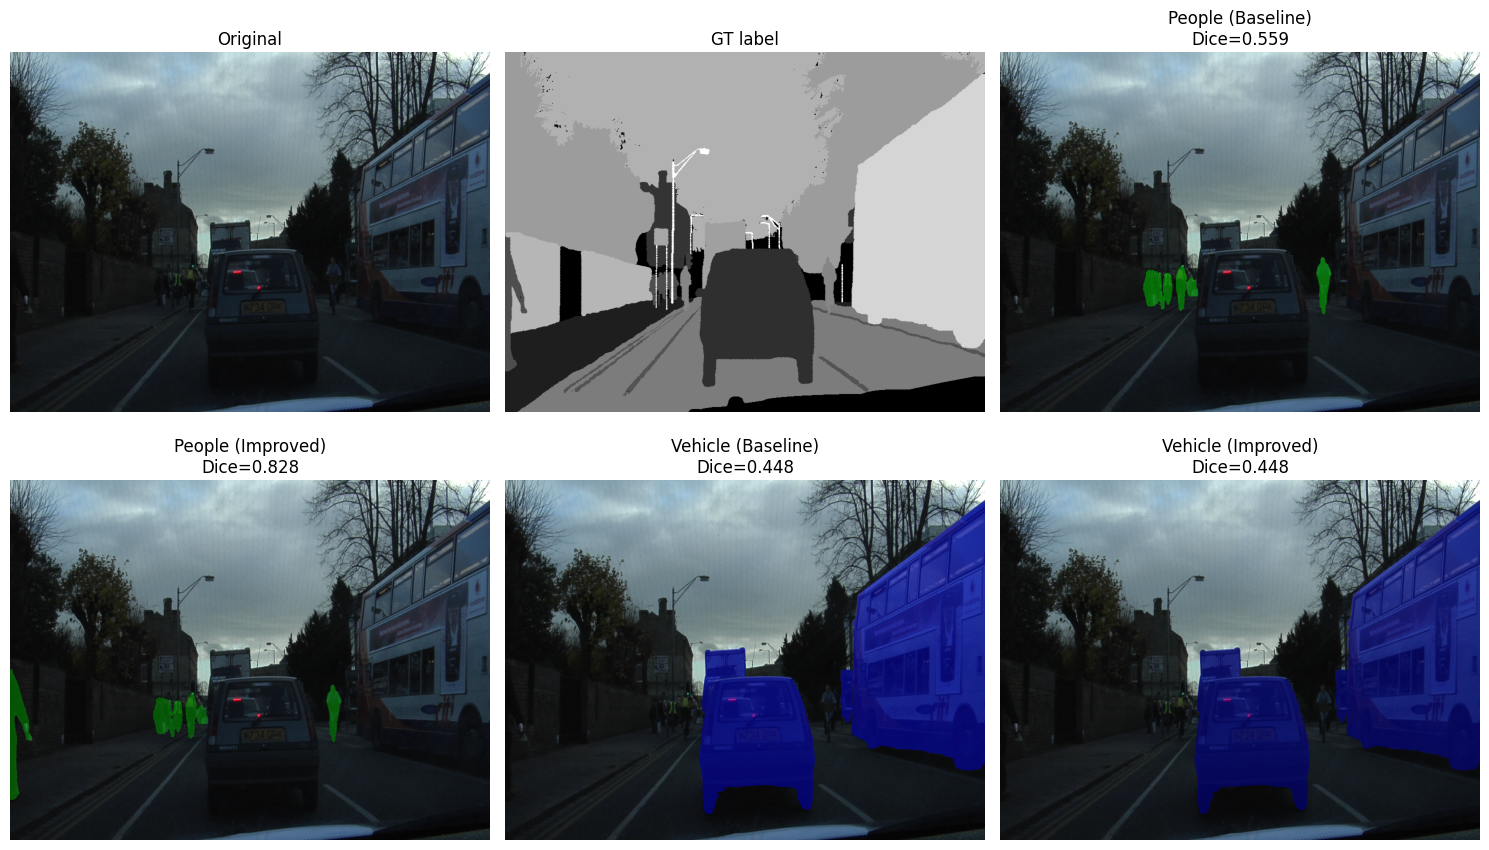

2025-09-11 17:17:09,751 | INFO | evaluate | Displaying 0001TP_009900.png


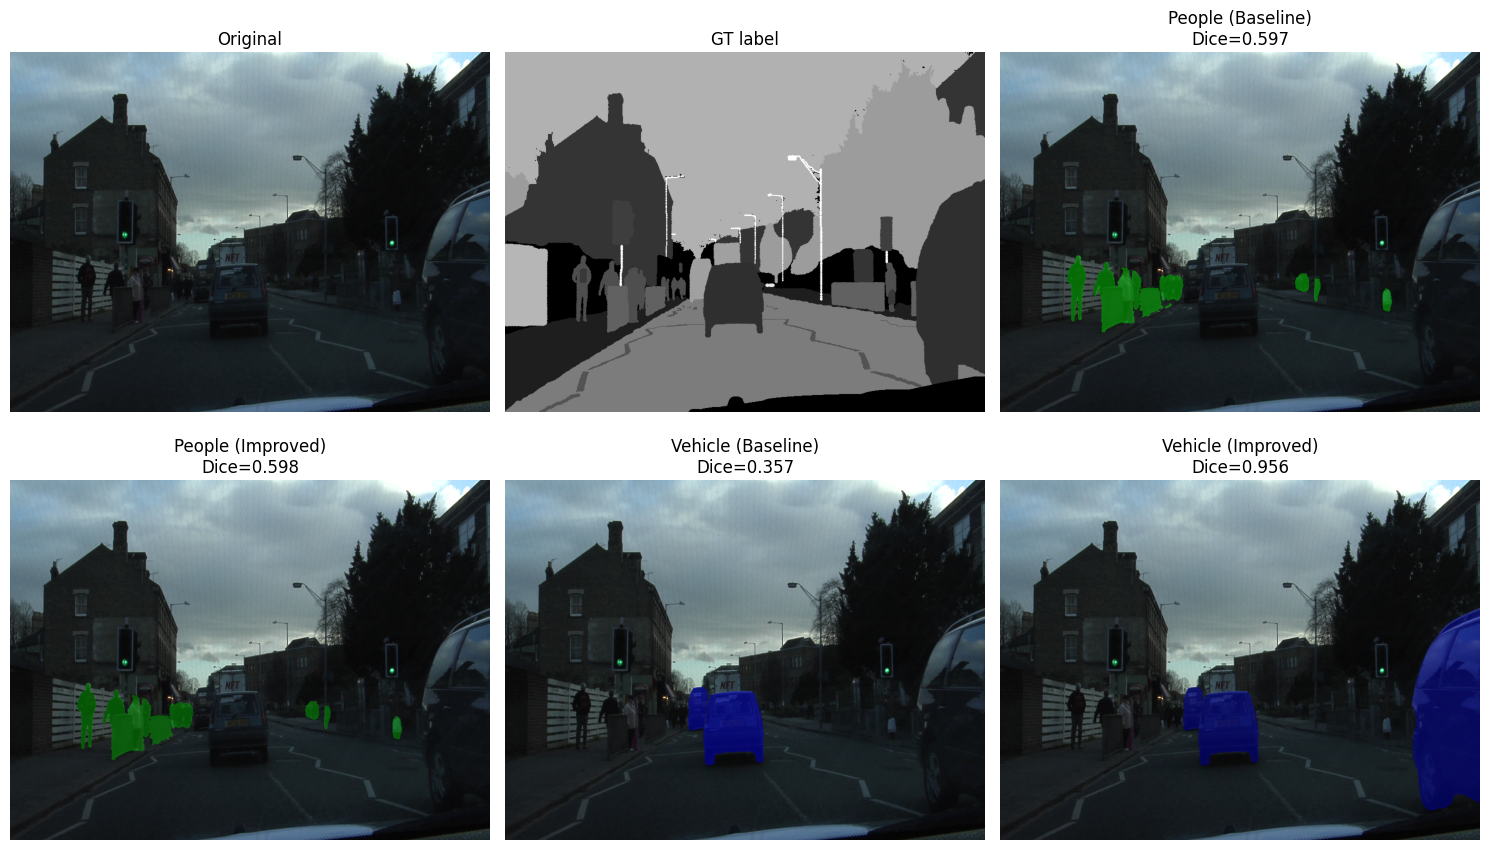

In [85]:
# EVALUATE.PY
import os
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# === Logger
def create_logger(log_dir: Path, name="evaluate", level="INFO"):
    log_dir.mkdir(parents=True, exist_ok=True)
    logger = logging.getLogger(name)
    logger.setLevel(getattr(logging, level.upper(), logging.INFO))
    logger.propagate = False
    if logger.handlers:
        for h in list(logger.handlers):
            logger.removeHandler(h)
    ch = logging.StreamHandler()
    fh = logging.FileHandler(log_dir / f"{name}.log", mode="w")
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(name)s | %(message)s")
    ch.setFormatter(fmt); fh.setFormatter(fmt)
    logger.addHandler(ch); logger.addHandler(fh)
    return logger

# === Overlay function
def overlay_mask(img, mask, color=(0,255,0), alpha=0.4):
    if mask.ndim == 3:
        mask = np.array(Image.fromarray(mask).convert("L"))
    mask_bool = mask > 127
    out = img.copy()
    col = np.array(color, dtype=np.uint8)
    out[mask_bool] = (col * alpha + out[mask_bool] * (1 - alpha)).astype(np.uint8)
    return out

# === Display function
def show_result(row, paths, use_overlays=True):
    img_name = row["image"]
    stem = Path(img_name).stem

    img_path = paths["img_dir"] / img_name
    lbl_path = paths["lbl_dir"] / f"{stem}.png"
    if not lbl_path.exists():
        lbl_path = paths["lbl_dir"] / f"{stem}_L.png"

    # Masks
    b_people = np.array(Image.open(paths["mask_b"] / f"{stem}_people.png"))
    b_vehicle= np.array(Image.open(paths["mask_b"] / f"{stem}_vehicle.png"))
    i_people = np.array(Image.open(paths["mask_i"] / f"{stem}_people.png"))
    i_vehicle= np.array(Image.open(paths["mask_i"] / f"{stem}_vehicle.png"))

    img = np.array(Image.open(img_path).convert("RGB"))
    gt  = np.array(Image.open(lbl_path).convert("L"))

    if use_overlays:
        P_BASE = overlay_mask(img, b_people, color=(0,255,0))
        P_IMPR = overlay_mask(img, i_people, color=(0,200,0))
        V_BASE = overlay_mask(img, b_vehicle, color=(0,0,255))
        V_IMPR = overlay_mask(img, i_vehicle, color=(0,0,200))
        cmap=None
    else:
        P_BASE, P_IMPR, V_BASE, V_IMPR = b_people, i_people, b_vehicle, i_vehicle
        cmap="gray"

    fig, ax = plt.subplots(2, 3, figsize=(15, 9))
    ax = ax.ravel()
    ax[0].imshow(img); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(gt, cmap="gray"); ax[1].set_title("GT label"); ax[1].axis("off")
    ax[2].imshow(P_BASE, cmap=cmap); ax[2].set_title(f"People (Baseline)\nDice={row['dice_people_baseline']:.3f}"); ax[2].axis("off")
    ax[3].imshow(P_IMPR, cmap=cmap); ax[3].set_title(f"People (Improved)\nDice={row['dice_people_improved']:.3f}"); ax[3].axis("off")
    ax[4].imshow(V_BASE, cmap=cmap); ax[4].set_title(f"Vehicle (Baseline)\nDice={row['dice_vehicle_baseline']:.3f}"); ax[4].axis("off")
    ax[5].imshow(V_IMPR, cmap=cmap); ax[5].set_title(f"Vehicle (Improved)\nDice={row['dice_vehicle_improved']:.3f}"); ax[5].axis("off")

    plt.tight_layout()
    plt.show()

# === Paths
OUT_ROOT = Path("/kaggle/working/a3_sam2_camvid")
IMG_DIR = Path("/kaggle/input/camvid/CamVid/val")
LBL_DIR = Path("/kaggle/input/camvid/CamVid/val_labels")
CSV_PATH = OUT_ROOT / "camvid_val_dice.csv"
MASK_B = OUT_ROOT / "masks_baseline"
MASK_I = OUT_ROOT / "masks_improved"
LOG_DIR = OUT_ROOT / "logs"

logger = create_logger(LOG_DIR)
logger.info("Starting selected image display")

# Load CSV
df = pd.read_csv(CSV_PATH)

# Specify images to display
selected_images = ["0001TP_009900.png", "0001TP_009060.png"]
subset = df[df["image"].isin(selected_images)]
logger.info(f"Displaying selected images: {selected_images}")

paths = {
    "img_dir": IMG_DIR,
    "lbl_dir": LBL_DIR,
    "mask_b": MASK_B,
    "mask_i": MASK_I,
}

# Show each selected image
for _, row in subset.iterrows():
    logger.info(f"Displaying {row['image']}")
    try:
        show_result(row, paths, use_overlays=True)
    except Exception as e:
        logger.error(f"Failed to display {row['image']}: {e}")


In [82]:
import pandas as pd
from pathlib import Path

# --- Configuration ---
# Make sure this path matches where your CSV is saved
CSV_PATH = Path("/kaggle/working/a3_sam2_camvid/camvid_val_dice.csv")

# --- 1. Load the Results CSV ---
if not CSV_PATH.exists():
    print(f"ERROR: Results file not found at {CSV_PATH}")
    print("Please run your main evaluation notebook first to generate the CSV.")
else:
    df = pd.read_csv(CSV_PATH)
    print(f"Successfully loaded {len(df)} results from {CSV_PATH}\n")

    # --- 2. Calculate the Mean Scores ---
    mean_scores = {
        'dice_people_baseline': df['dice_people_baseline'].mean(),
        'dice_vehicle_baseline': df['dice_vehicle_baseline'].mean(),
        'dice_people_improved': df['dice_people_improved'].mean(),
        'dice_vehicle_improved': df['dice_vehicle_improved'].mean()
    }

    # --- 3. Calculate the Mean Gain ---
    mean_gain_people = mean_scores['dice_people_improved'] - mean_scores['dice_people_baseline']
    mean_gain_vehicle = mean_scores['dice_vehicle_improved'] - mean_scores['dice_vehicle_baseline']

    # --- 4. Create and Display the Final Summary Table ---
    summary_data = {
        "Category": ["People", "Vehicle"],
        "Baseline Mean Dice": [mean_scores['dice_people_baseline'], mean_scores['dice_vehicle_baseline']],
        "Improved Mean Dice": [mean_scores['dice_people_improved'], mean_scores['dice_vehicle_improved']],
        "Mean Gain": [mean_gain_people, mean_gain_vehicle]
    }

    summary_df = pd.DataFrame(summary_data).set_index("Category")

    # Format the table for better readability
    summary_df = summary_df.applymap('{:+.4f}'.format) # Show sign and 4 decimal places

    print("="*60)
    print("      OVERALL PERFORMANCE SUMMARY (ENTIRE VALIDATION SET)")
    print("="*60)
    print(summary_df)
    print("="*60)

Successfully loaded 100 results from /kaggle/working/a3_sam2_camvid/camvid_val_dice.csv

      OVERALL PERFORMANCE SUMMARY (ENTIRE VALIDATION SET)
         Baseline Mean Dice Improved Mean Dice Mean Gain
Category                                                
People              +0.6071            +0.6107   +0.0037
Vehicle             +0.5625            +0.7022   +0.1397


/tmp/ipykernel_36/3837019628.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df = summary_df.applymap('{:+.4f}'.format) # Show sign and 4 decimal places
